In [32]:
import matplotlib.pyplot as plt
from face_swap.image_preprocessing import *
from face_swap.utils import *
from face_swap.keypoints import *
import tqdm.notebook as tq

In [33]:
source_img_path = "data/f1.jpg"
target_img_path = "data/macron2.jpg"

source_img = read_image(source_img_path)
target_img = read_image(target_img_path)

s_aligned, s_ldmks = get_aligned_image(source_img)
t_aligned, t_ldmks = get_aligned_image(target_img)

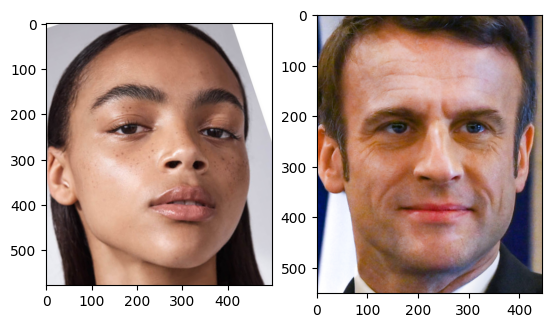

In [34]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_aligned)
axarr[1].imshow(t_aligned)

In [35]:
T = [107, 51, 9]
s_zone_ldmks = get_zone_landmarks(T, s_ldmks)
t_zone_ldmks = get_zone_landmarks(T, t_ldmks)

s_zone_patch = get_patch_image(s_aligned, T, s_ldmks)
t_zone_patch = get_patch_image(t_aligned, T, t_ldmks)

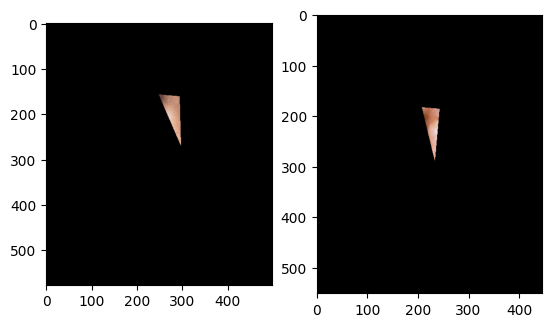

In [36]:
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(s_zone_patch)
axarr[1].imshow(t_zone_patch)

In [37]:
rotation_matrix, _ = cv2.estimateAffinePartial2D(s_zone_ldmks, t_zone_ldmks)
s_rotated = cv2.warpAffine(
    s_zone_patch, 
    rotation_matrix, 
    (t_zone_patch.shape[1], t_zone_patch.shape[0])
)
add = cv2.addWeighted(s_rotated, 0.3, t_zone_patch, 0.7, 0)
s_zone_ldmks = np.dot(rotation_matrix, np.row_stack((s_zone_ldmks[:, 0], s_zone_ldmks[:, 1], np.ones(s_zone_ldmks.shape[0])))).T
convexhull2 = cv2.convexHull(t_zone_ldmks)
s_zone_ldmks = s_zone_ldmks.astype(np.uint8)
s_aligned = s_rotated.copy()

height, width, _ = s_aligned.shape
s_ldmks_norm = np.array([(lm[0] / width, lm[1] / height) for lm in s_ldmks])

In [38]:
rect1 = cv2.boundingRect(s_zone_ldmks)
(x, y, w, h) = rect1
cropped_triangle = s_aligned[y: y + h, x: x + w]
cropped_tr1_mask = np.zeros((h, w), np.uint8)

points = np.array([[s_zone_ldmks[0][0] - x, s_zone_ldmks[0][1] - y],
                    [s_zone_ldmks[1][0] - x, s_zone_ldmks[1][1] - y],
                    [s_zone_ldmks[2][0] - x, s_zone_ldmks[2][1] - y]], np.int32)
cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

rect2 = cv2.boundingRect(t_zone_ldmks)
(x, y, w, h) = rect2
cropped_triangle = t_aligned[y: y + h, x: x + w]
cropped_tr2_mask = np.zeros((h, w), np.uint8)

points2 = np.array([[t_zone_ldmks[0][0] - x, t_zone_ldmks[0][1] - y],
                    [t_zone_ldmks[1][0] - x, t_zone_ldmks[1][1] - y],
                    [t_zone_ldmks[2][0] - x, t_zone_ldmks[2][1] - y]], np.int32)
cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [39]:
points = np.float32(points)
points2 = np.float32(points2)
M = cv2.getAffineTransform(points, points2)
warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h),borderMode=cv2.BORDER_REPLICATE)
warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)


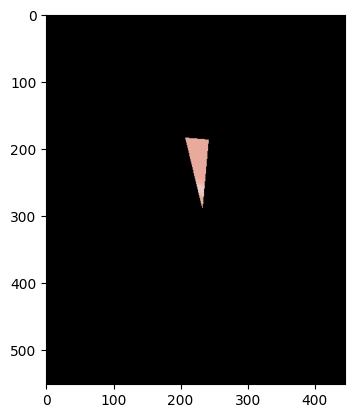

In [40]:
img2_new_face = np.zeros_like(t_aligned)
image = t_aligned.copy()
seam_clone = s_aligned.copy()
result = t_aligned.copy()
out_image = t_aligned.copy()
img2_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img2_new_face = np.zeros_like(image)
seamlessclone = t_aligned.copy()

img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]

img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
_, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255,
                                                                       cv2.THRESH_BINARY_INV)
warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle,
                                                              mask=mask_triangles_designed)

img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area
plt.imshow(img2_new_face)

In [41]:
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)
img2_head_noface = cv2.bitwise_and(seam_clone, seam_clone, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, seam_clone,img2_head_mask, center_face2, cv2.MIXED_CLONE)

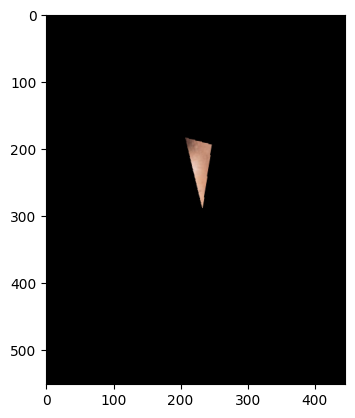

In [42]:
plt.imshow(seamlessclone)

In [43]:
img2_face_mask.shape

(551, 446)

In [ ]:
import cv2
import numpy as np

from face_swap_v2.image_preprocessing import align
from face_swap_v2.keypoints import MESH
from face_swap_v2.utils import read_image, save_image


def merge(
        source_image: np.nparray, 
        target_image: np.ndarray,
)


def run(
        source_path: str,
        target_path: str,
        output_path: str
):
    source_img = read_image(source_path)
    target_img = read_image(target_path)

    s_aligned, s_ldmks = align(source_img)
    t_aligned, t_ldmks = align(target_img)

    ###
    seam_clone = t_aligned.copy()
    result = t_aligned.copy()
    t_grayscale = cv2.cvtColor(t_aligned, cv2.COLOR_BGR2GRAY)
    t_new_face = np.zeros_like(t_aligned) #
    merged_face = t_aligned.copy()

    t_hull = cv2.convexHull(t_ldmks)

    for i in range(0, len(MESH) // 3):

        zone_index = [MESH[i * 3], MESH[i * 3 + 1], MESH[i * 3 + 2]]

        s_zone_ldmks = s_ldmks[zone_index]
        s_zone_rect = cv2.boundingRect(s_zone_ldmks)
        (x, y, w, h) = s_zone_rect
        s_zone = s_aligned[y: y + h, x: x + w]
        s_zone_mask = np.zeros((h, w), np.uint8)
        
        s_zone_ldmks[:, 0] -= x
        s_zone_ldmks[:, 1] -= y

        cv2.fillConvexPoly(s_zone_mask, s_zone_ldmks, 255)
        
        ###
        t_zone_ldmks = t_ldmks[zone_index]
        t_zone_rect = cv2.boundingRect(t_zone_ldmks)
        (x, y, w, h) = t_zone_rect
        t_zone_mask = np.zeros((h, w), np.uint8)
        
        t_zone_ldmks[:, 0] -= x
        t_zone_ldmks[:, 1] -= y

        cv2.fillConvexPoly(t_zone_mask, t_zone_ldmks, 255)

        #### 
        rotation_matrix = cv2.getAffineTransform(
            s_zone_ldmks.astype(np.float32), 
            t_zone_ldmks.astype(np.float32)
        )
        
        warped_zone = cv2.warpAffine(
            s_zone, 
            rotation_matrix, 
            (w, h), 
            borderMode=cv2.BORDER_REPLICATE
        )

        warped_zone = cv2.bitwise_and(warped_zone, warped_zone, mask=t_zone_mask)

        # Reconstructing destination face
        t_new_face_rect = t_new_face[y: y + h, x: x + w]
        t_new_face_rect_grayscale = cv2.cvtColor(t_new_face_rect, cv2.COLOR_BGR2GRAY)
        _, merged_mask = cv2.threshold(
            t_new_face_rect_grayscale, 
            1, 
            255,
            cv2.THRESH_BINARY_INV
        )
        warped_zone = cv2.bitwise_and(warped_zone, warped_zone, mask=merged_mask)
        t_new_face_rect = cv2.add(t_new_face_rect, warped_zone)
        t_new_face[y: y + h, x: x + w] = t_new_face_rect
  
    t_faceless_mask = cv2.fillConvexPoly(np.zeros_like(t_grayscale), t_hull, 255)
    t_face_mask = cv2.bitwise_not(t_faceless_mask)

    t_faceless = cv2.bitwise_and(seam_clone, seam_clone, mask=t_face_mask)
    result = cv2.add(t_faceless, t_new_face)

    (x, y, w, h) = cv2.boundingRect(t_hull)
    t_face_center = (x + w // 2, y + h // 2)

    merged_face = cv2.seamlessClone(
        result, 
        seam_clone, 
        t_faceless_mask, 
        t_face_center, 
        cv2.MIXED_CLONE
    )
    
    save_image(merged_face, output_path)


if __name__ == '__main__':
    source_img_path = "data/f1.jpg"
    target_img_path = "data/macron2.jpg"
    output_img_path = "output/merged.jpg"

    run(source_img_path, target_img_path, output_img_path)